# 3. Modelado, Evaluación y Selección (MLflow Pipeline)

**Objetivo:** Construir un pipeline de entrenamiento robusto que integre el conocimiento adquirido en el análisis exploratorio (EDA) y en la sección de feature engineering y compare múltiples algoritmos utilizando la métrica **F1-Score**.

**Estrategia:**
1.  **Pipeline Scikit-learn:** Encapsular preprocesamiento y modelo para garantizar reproducibilidad.
2.  **Feature Engineering "In-Pipeline":** Calcular `BalanceSalaryRatio` y `TenureAgeRatio`.
3.  **Tracking con MLflow:** Registrar cada experimento para comparar métricas objetivamente.
4.  **Optimización:** Ajustar hiperparámetros del modelo ganador.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
import os
from pathlib import Path
import sys

project_root = Path.cwd().resolve()
if project_root.name == "notebooks":
    project_root = project_root.parent

root_str = str(project_root)
if root_str not in sys.path:
    sys.path.insert(0, root_str)

from src.config import RAW_TRAIN_PATH, RAW_TEST_PATH, RANDOM_SEED, NUMERIC_FEATURES, CATEGORICAL_FEATURES

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
os.makedirs("../models", exist_ok=True) 
os.makedirs("../submissions", exist_ok=True)

df_train = pd.read_csv(RAW_TRAIN_PATH)
df_test = pd.read_csv(RAW_TEST_PATH)

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

db_path = os.path.join(os.getcwd(), "..", "mlflow.db") 
tracking_uri = f"sqlite:///{db_path}"

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("Bank_Churn_Prediction")

print(f"✅ MLflow logueando en: {tracking_uri}")

[2025-11-19 23:52:04][src.config][INFO] Cargando parámetros desde /home/miguel/Documents/UIMP/aprendizaje_automatico/ml-finance-churn-model/config/params.yaml
[2025-11-19 23:52:04][src.config][INFO] Features dinámicas cargadas desde selected_features.json
[2025-11-19 23:52:04][src.config][INFO] Features dinámicas: comments='Variables seleccionadas automaticamente por Boruta' date='2025-11-19 23:04' features=FeaturesDetail(numeric=['Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'BalanceSalaryRatio', 'TenureAgeRatio', 'CreditScore', 'EstimatedSalary'], categorical=['Geography', 'Gender'])
[2025-11-19 23:52:04][src.config][INFO] 🚀 Usando configuración de features DINÁMICA (Boruta).


Train shape: (8000, 13)
Test shape: (2000, 12)


2025/11/19 23:52:05 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/11/19 23:52:05 INFO mlflow.store.db.utils: Updating database tables
2025-11-19 23:52:05 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-11-19 23:52:05 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025-11-19 23:52:06 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-11-19 23:52:06 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


✅ MLflow logueando en: sqlite:////home/miguel/Documents/UIMP/aprendizaje_automatico/ml-finance-churn-model/notebooks/../mlflow.db


## 1. Definición de Variables (Golden Features)
Basado en el análisis de Boruta previo, definimos explícitamente qué variables entran al modelo.
* **Nota:** `EstimatedSalary` y `Tenure` NO están en la lista final, pero se usarán internamente para calcular los ratios antes de ser descartadas.

In [2]:
print("Features seleccionadas para el modelo final:", NUMERIC_FEATURES + CATEGORICAL_FEATURES)

Features seleccionadas para el modelo final: ['Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'BalanceSalaryRatio', 'TenureAgeRatio', 'CreditScore', 'EstimatedSalary', 'Geography', 'Gender']


## 2. Ingeniería de Características en el Pipeline
Creamos una clase `FeatureEngineer` compatible con Scikit-learn. Esto es crucial: permite que cuando lleguen los datos de Test (que no tienen los ratios calculados), el pipeline los genere automáticamente sin intervención manual.

In [3]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_out = X.copy()
        
        if 'EstimatedSalary' in X_out.columns and 'Balance' in X_out.columns:
            X_out['BalanceSalaryRatio'] = X_out['Balance'] / (X_out['EstimatedSalary'] + 1e-6)
            
        if 'Tenure' in X_out.columns and 'Age' in X_out.columns:
            X_out['TenureAgeRatio'] = X_out['Tenure'] / (X_out['Age'] + 1e-6)
            
        return X_out

In [4]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ],
    remainder='drop' 
)

## 3. Experimentación con MLflow
Evaluamos 4 modelos distintos utilizando **Validación Cruzada (5-Folds)** y optimizando para la métrica **F1-Score** (dado el desbalanceo de clases).

Iniciando experimentos...
Modelo: CatBoost | F1 SMOTE: 0.6069 | Mejor Umbral: 0.5463
Modelo: LGBM | F1 SMOTE: 0.5958 | Mejor Umbral: 0.4965
Modelo: XGBoost | F1 SMOTE: 0.5748 | Mejor Umbral: 0.5952
Modelo: Random_Forest | F1 SMOTE: 0.6008 | Mejor Umbral: 0.4948
Modelo: MLP_Network | F1 SMOTE: 0.5984 | Mejor Umbral: 0.4807


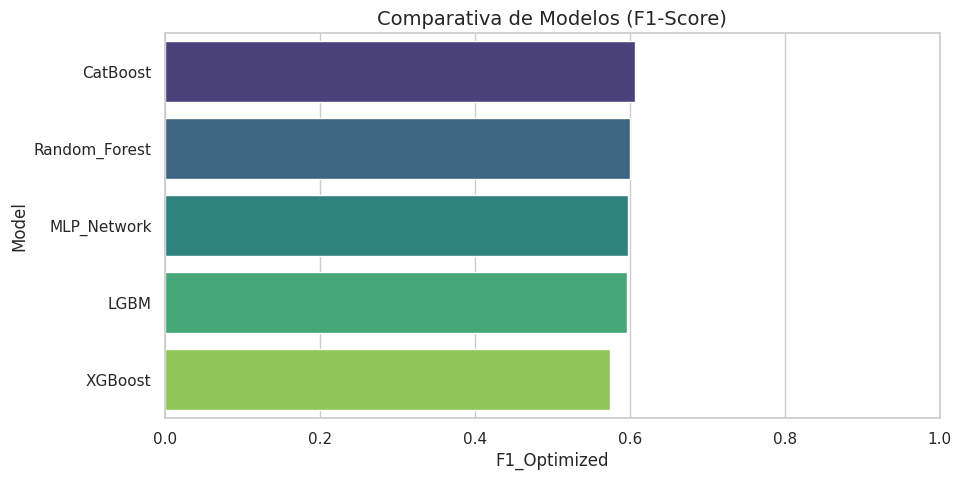

In [13]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.neural_network import MLPClassifier

X = df_train.drop(columns=['Exited', 'CustomerId', 'Surname'], errors='ignore')
y = df_train['Exited']


models = {
    "CatBoost": CatBoostClassifier(verbose=0, auto_class_weights='Balanced', random_state=42),
    "LGBM": LGBMClassifier(is_unbalance=True, random_state=42, verbose=-1),
    "XGBoost": XGBClassifier(scale_pos_weight=4, eval_metric='logloss', random_state=42),
    "Random_Forest": RandomForestClassifier(class_weight='balanced', n_estimators=150, max_depth=10, random_state=42),
    "MLP_Network": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=0.01,
        batch_size=64,
        learning_rate_init=0.001,
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
    )
}

mlflow.set_experiment("Bank_Churn_Prediction_V1")
results_advanced = []
results = []

print("Iniciando experimentos...")
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        
        pipeline = ImbPipeline(steps=[
            ('engineer', FeatureEngineer()),     
            ('preprocessor', preprocessor),
            ('resampler', SMOTE(random_state=42, sampling_strategy=0.5)), 
            ('classifier', model)
        ])
        
        # 2. VALIDACIÓN CRUZADA MANUAL (Para poder ajustar el umbral)
        # Necesitamos 'predict_proba', cross_val_score no nos sirve aquí para tunear
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        fold_f1s = []
        best_thresholds = []
        
        # Iteramos por los folds manualmente
        for train_idx, val_idx in cv.split(X, y):
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
            
            # Entrenar (SMOTE se aplica solo aquí dentro automáticamente)
            pipeline.fit(X_train_fold, y_train_fold)
            
            # Predecir Probabilidades (No clases 0/1)
            y_proba = pipeline.predict_proba(X_val_fold)[:, 1]
            
            # --- THRESHOLD TUNING ---
            # Calculamos la curva Precision-Recall para encontrar el corte óptimo
            precisions, recalls, thresholds = precision_recall_curve(y_val_fold, y_proba)
            
            # Calcular F1 para todos los umbrales posibles
            # F1 = 2 * (P * R) / (P + R)
            numerator = 2 * (precisions * recalls)
            denominator = (precisions + recalls)
            # Evitar división por cero
            f1_scores = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)
            
            # Obtener el mejor F1 de este fold
            best_idx = np.argmax(f1_scores)
            fold_f1s.append(f1_scores[best_idx])
            best_thresholds.append(thresholds[best_idx])
        
        # Promedios finales
        avg_f1 = np.mean(fold_f1s)
        avg_thresh = np.mean(best_thresholds)
        
        print(f"Modelo: {name} | F1 SMOTE: {avg_f1:.4f} | Mejor Umbral: {avg_thresh:.4f}")
        
        # 3. Loguear en MLflow
        mlflow.log_param("resampling", "SMOTE_0.5")
        mlflow.log_metric("f1_mean_opt", avg_f1)
        mlflow.log_metric("optimal_threshold", avg_thresh)
        
        results_advanced.append({
            "Model": name,
            "F1_Optimized": avg_f1,
            "Threshold": avg_thresh,
            "Instance": model
        })

# Mostrar tabla de líderes
df_results = pd.DataFrame(results_advanced).sort_values("F1_Optimized", ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(data=df_results, x='F1_Optimized', y='Model', palette='viridis')
plt.title('Comparativa de Modelos (F1-Score)', fontsize=14)
plt.xlim(0, 1)
plt.show()

## 4. Optimización de Hiperparámetros (Tuning)
Seleccionamos el mejor modelo (generalmente XGBoost o LGBM en este dataset) y afinamos sus parámetros con `GridSearchCV`.

In [ ]:
base_pipeline = Pipeline(steps=[
    ('engineer', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(scale_pos_weight=4, random_state=42, n_jobs=-1))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [4, 6, 8],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    base_pipeline, 
    param_grid, 
    cv=5, 
    scoring='f1', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X, y)

print(f"\nMejores Parámetros: {grid_search.best_params_}")
print(f"Mejor F1-Score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

Iniciando ajuste de hiperparámetros (GridSearch)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Mejores Parámetros: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Mejor F1-Score: 0.5847


## 5. Evaluación Final y Matriz de Confusión
Evaluamos el mejor modelo sobre todo el conjunto de entrenamiento para ver dónde falla (Falsos Positivos vs Falsos Negativos).

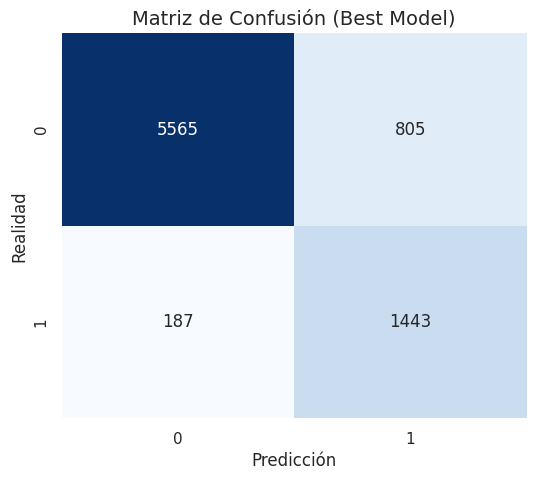

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      6370
           1       0.64      0.89      0.74      1630

    accuracy                           0.88      8000
   macro avg       0.80      0.88      0.83      8000
weighted avg       0.90      0.88      0.88      8000



In [ ]:
y_pred = best_model.predict(X)

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión (Best Model)', fontsize=14)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

print("Reporte de Clasificación:")
print(classification_report(y, y_pred))

## 6. Generación del Envío (Submission) para Kaggle
Aplicamos el pipeline completo al conjunto de test (`test.csv`). Gracias a la clase `FeatureEngineer`, los ratios se calculan automáticamente.

In [ ]:
X_test_kaggle = df_test.drop(columns=['Surname'], errors='ignore') 
ids = df_test['CustomerId']
X_test_kaggle = X_test_kaggle.drop(columns=['CustomerId'], errors='ignore')

predictions = best_model.predict(X_test_kaggle)

submission = pd.DataFrame({
    'CustomerId': ids,
    'Exited': predictions
})

save_path = '../submissions/submission_xgboost_optimized.csv'
submission.to_csv(save_path, index=False)

print(f"¡Archivo generado! Guardado en: {save_path}")
print(submission.head())

¡Archivo generado! Guardado en: ../submissions/submission_xgboost_optimized.csv
   CustomerId  Exited
0    15764618       0
1    15626385       0
2    15687413       0
3    15759067       1
4    15614049       0
